In [4]:
#import scvi
import scanpy as sc
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import anndata

In [7]:
import os

In [8]:
import random

In [ ]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

### Load data and reference model

In [10]:
adata = sc.read('/home/ubuntu/lagringshotellet/Users/Herman/data/zenodo/all_nk_cells.h5ad')

In [ ]:
adata_query = adata[adata.obs['condition'] != 'reference'].copy()

In [16]:
adata = adata[adata.obs['condition'] == 'reference'].copy()

In [ ]:
scvi_model = scvi.model.SCVI.load('pb_tissue_normal_ref_scvi', adata=adata)

#### Map query scvi model

In [ ]:
scvi.model.SCANVI.prepare_query_anndata(adata_query, scanvi_model)

INFO     Found 97.47352972009644% reference vars in query data.                                                    


/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/model/base/_archesmixin.py:211: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [ ]:
query_model = scvi.model.SCANVI.load_query_data(adata_query, scanvi_model)

In [ ]:
query_model.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0))

In [102]:
query_model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 40, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
plt.plot(query_model.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [171]:
adata_query.obsm['X_scVI'] = query_model.get_latent_representation()

In [172]:
adata_full = anndata.concat([adata, adata_query])

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [174]:
sc.pp.neighbors(adata_full, use_rep='X_scVI')
sc.tl.umap(adata_full)

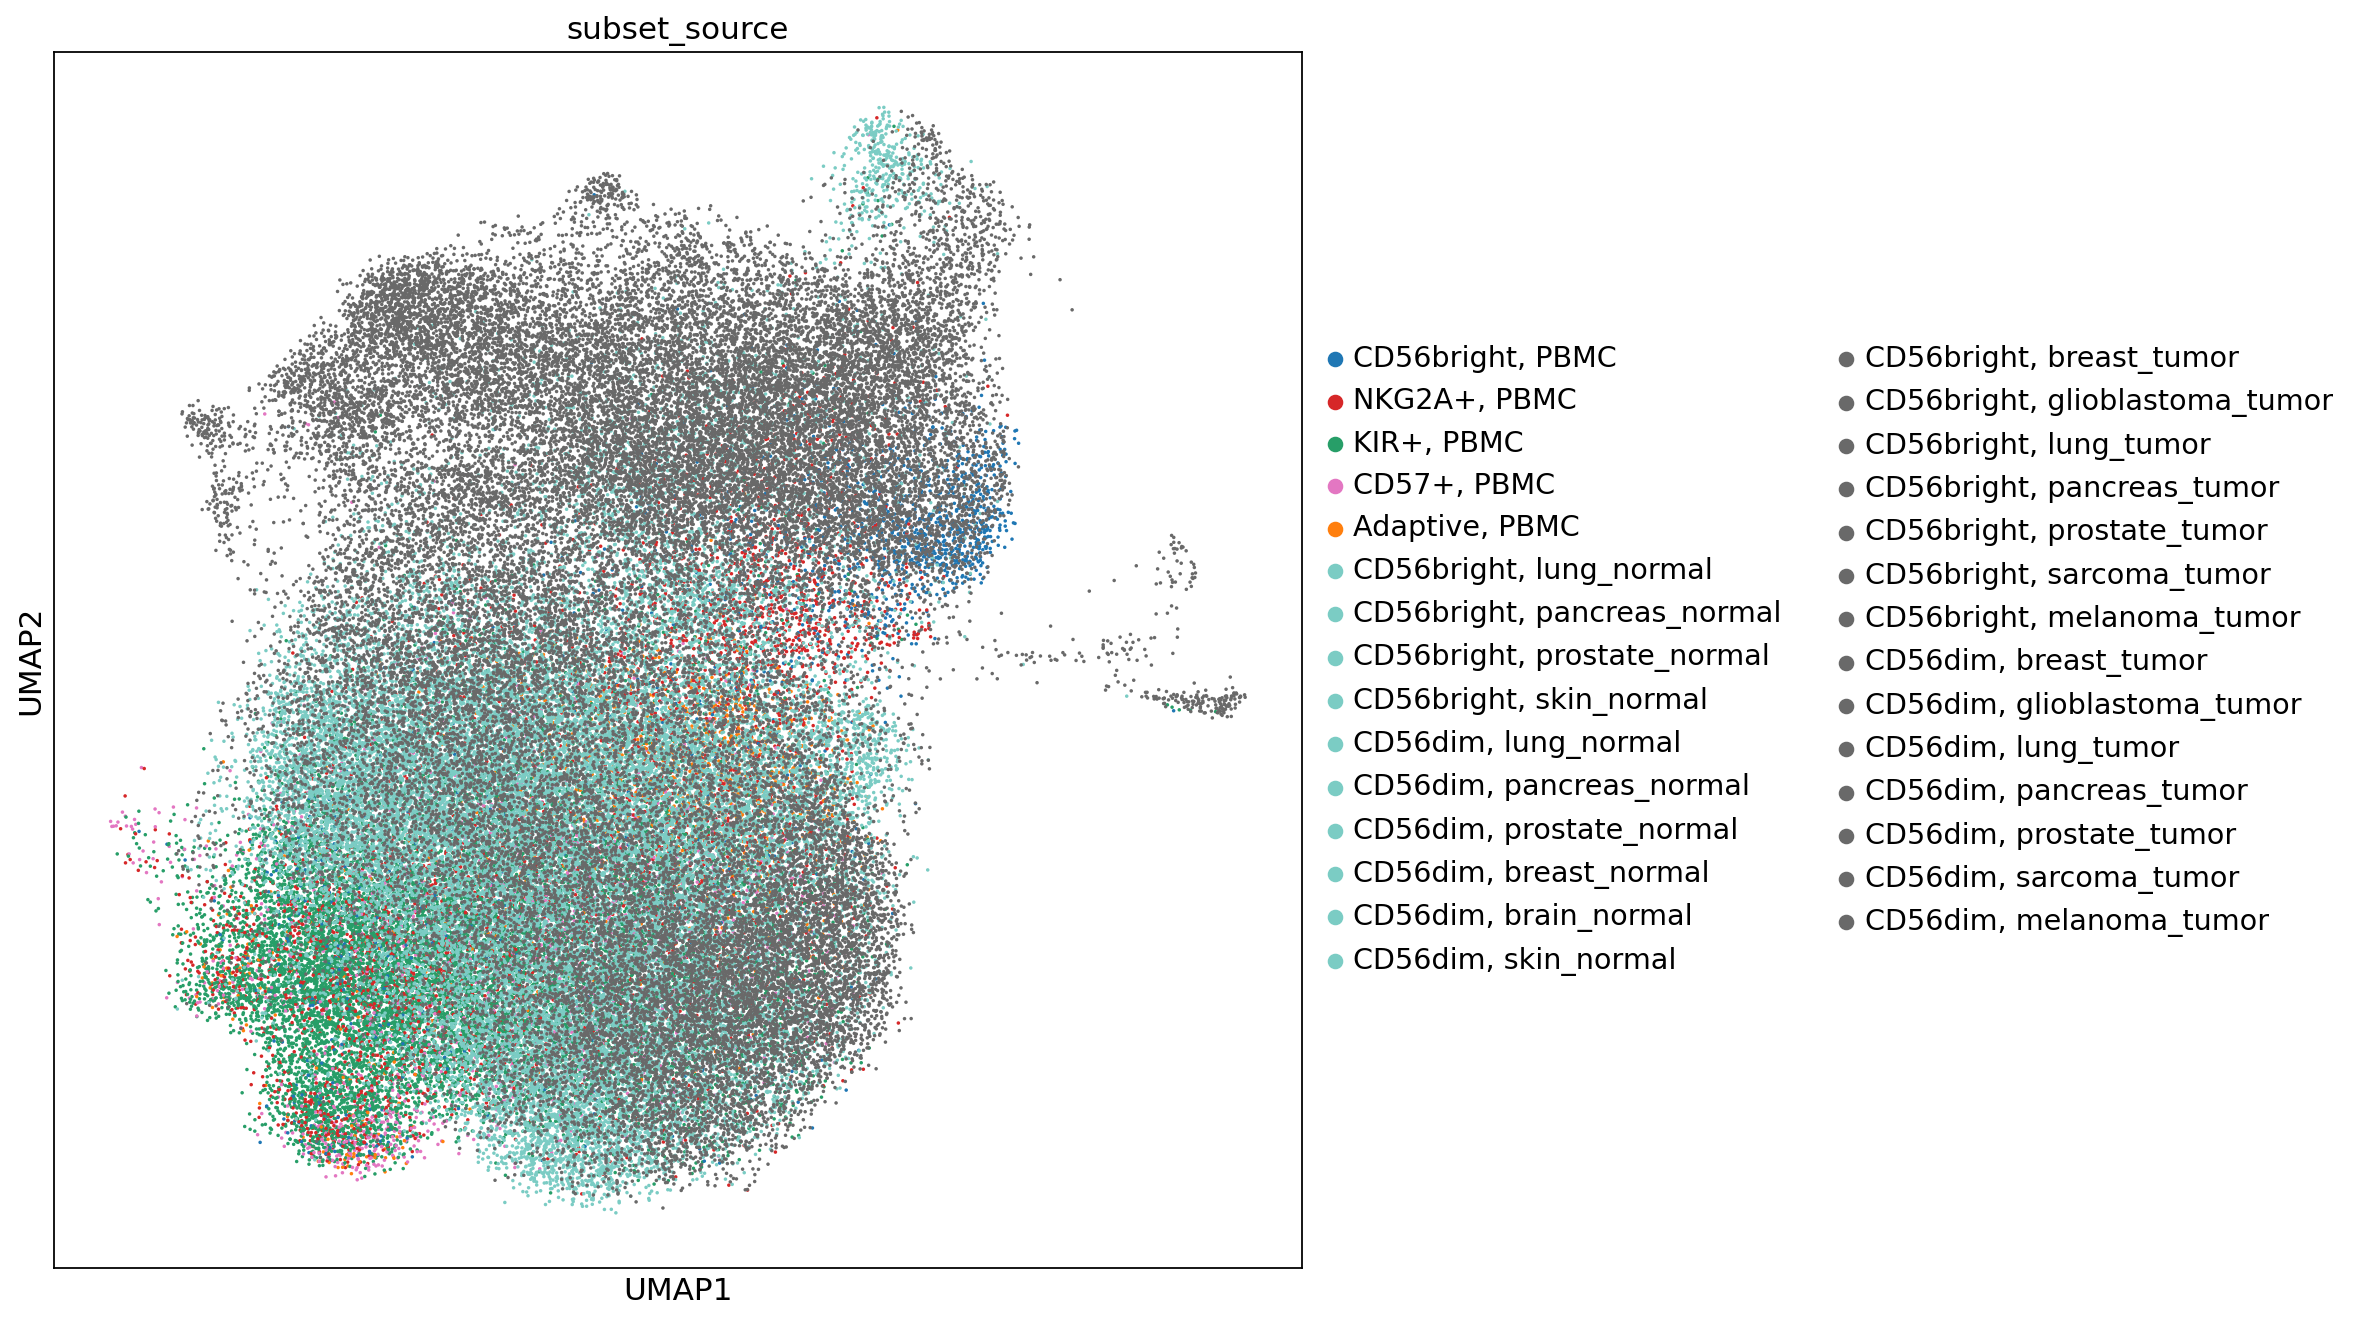

In [187]:
sc.pl.umap(adata_full, color='subset_source', s=10, save='subset_source_tumor_mapped.pdf')

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


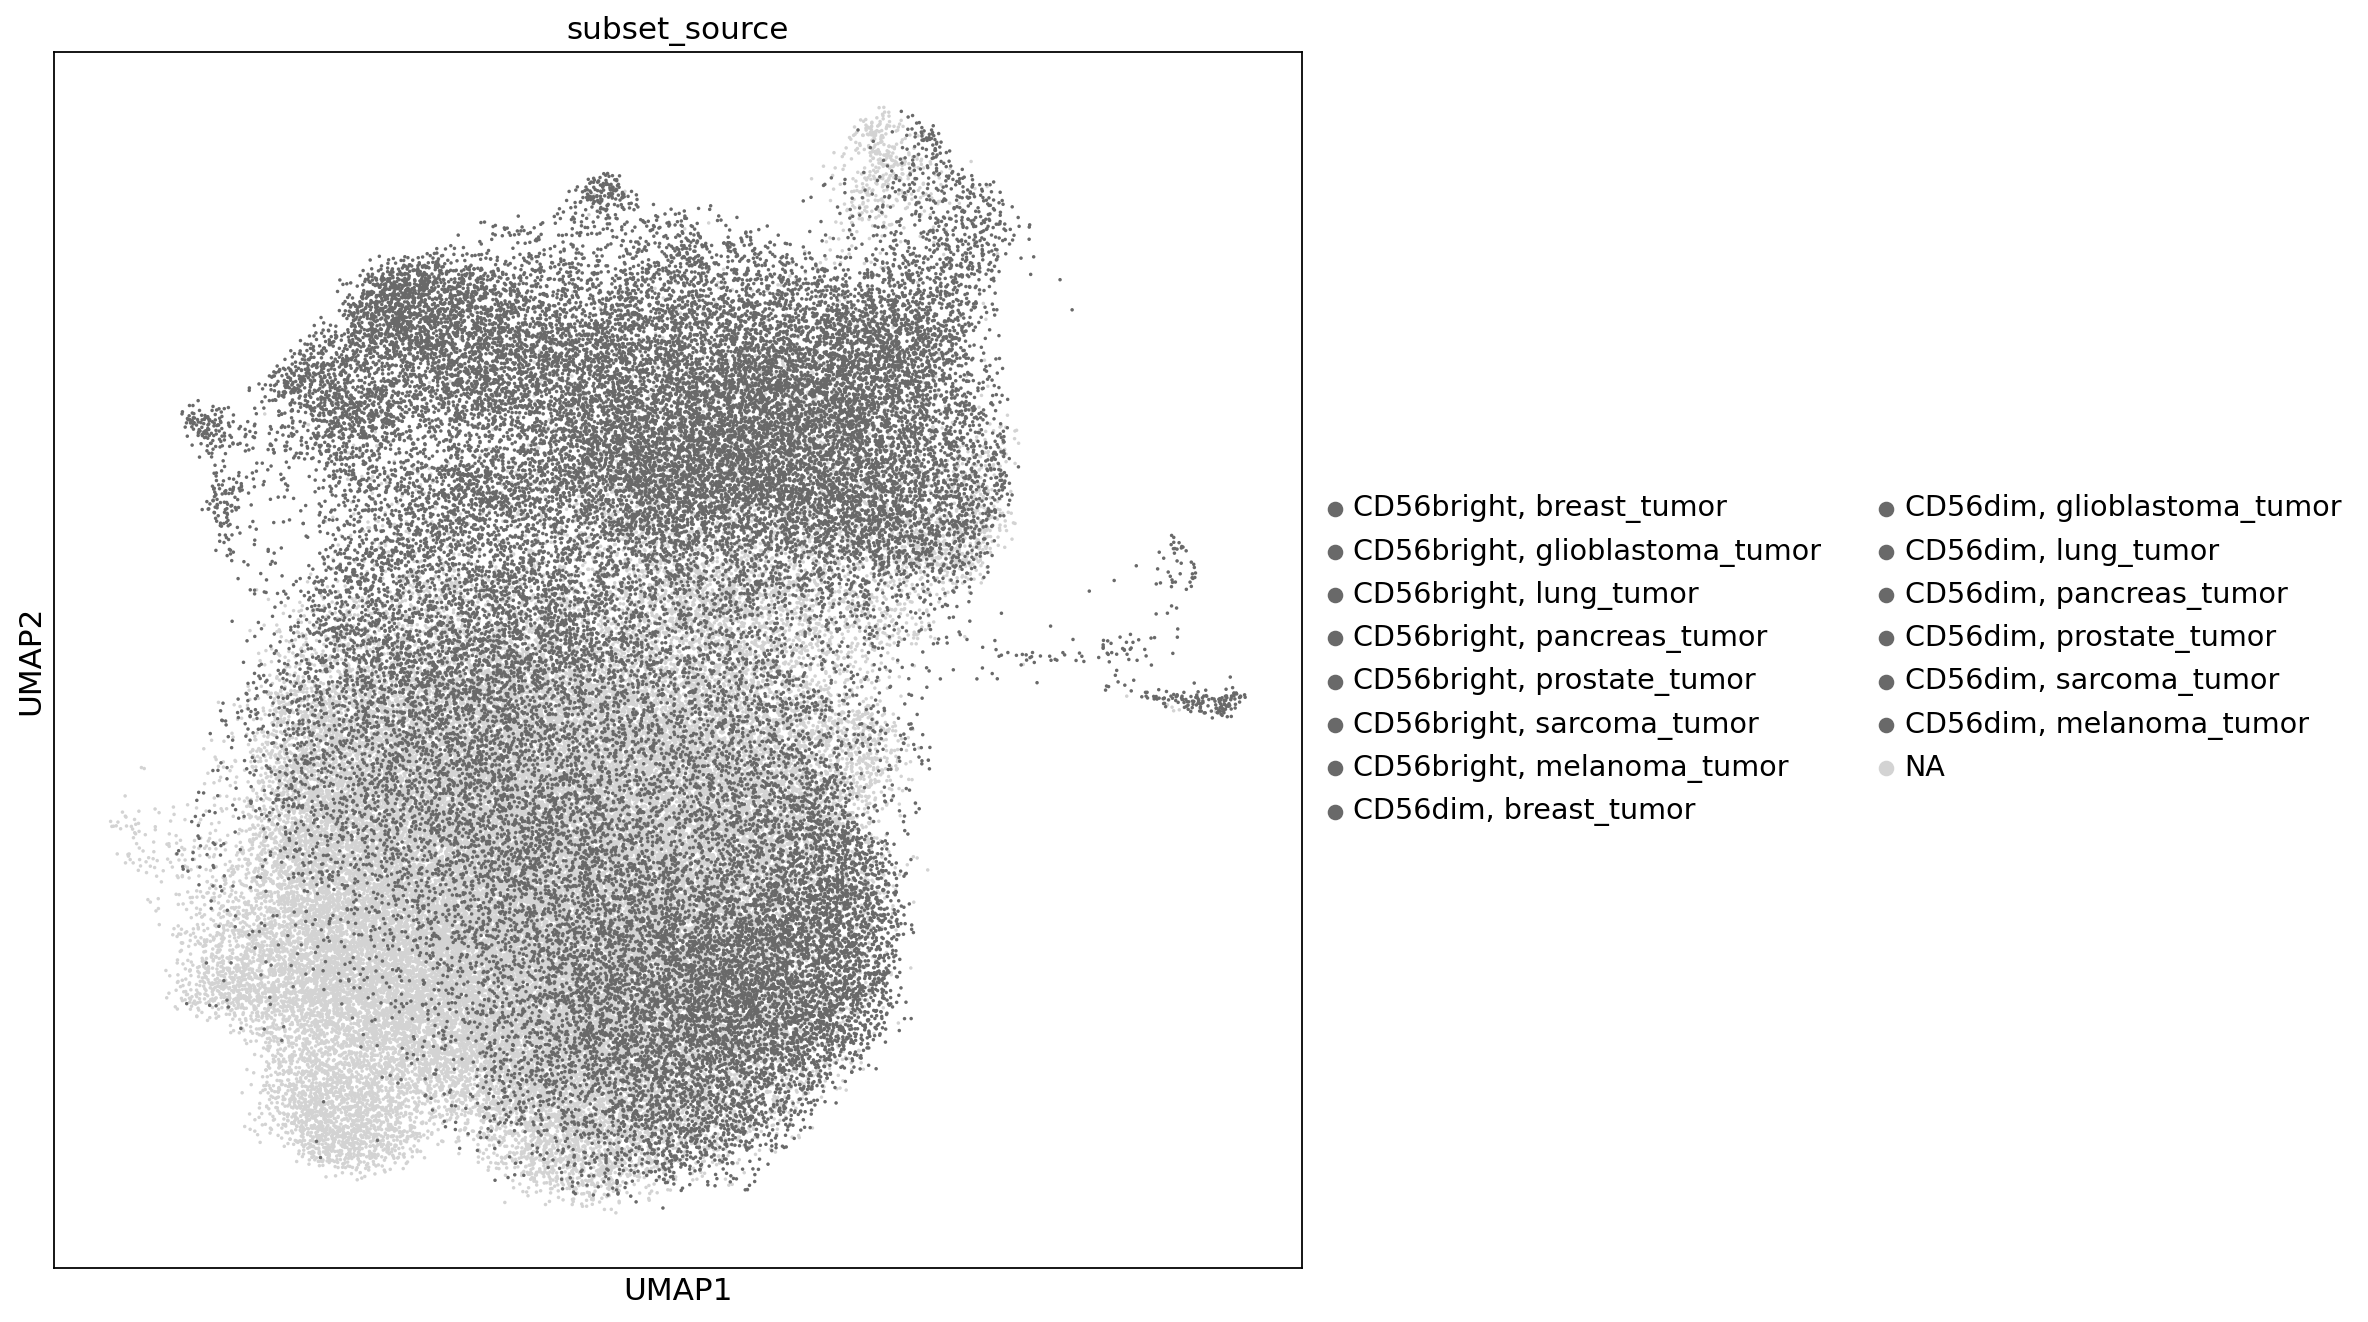

In [95]:
sc.pl.umap(adata_full, color='subset_source', s=10,
           groups=[x for x in adata_full.obs['subset_source'].cat.categories if 'tumor' in x],
              save=f'mapped_tumor_ref_map_tumor_nk.pdf')

In [166]:
paga_adata_full = sc.tl.paga(adata_full, groups='subset_source', copy=True)

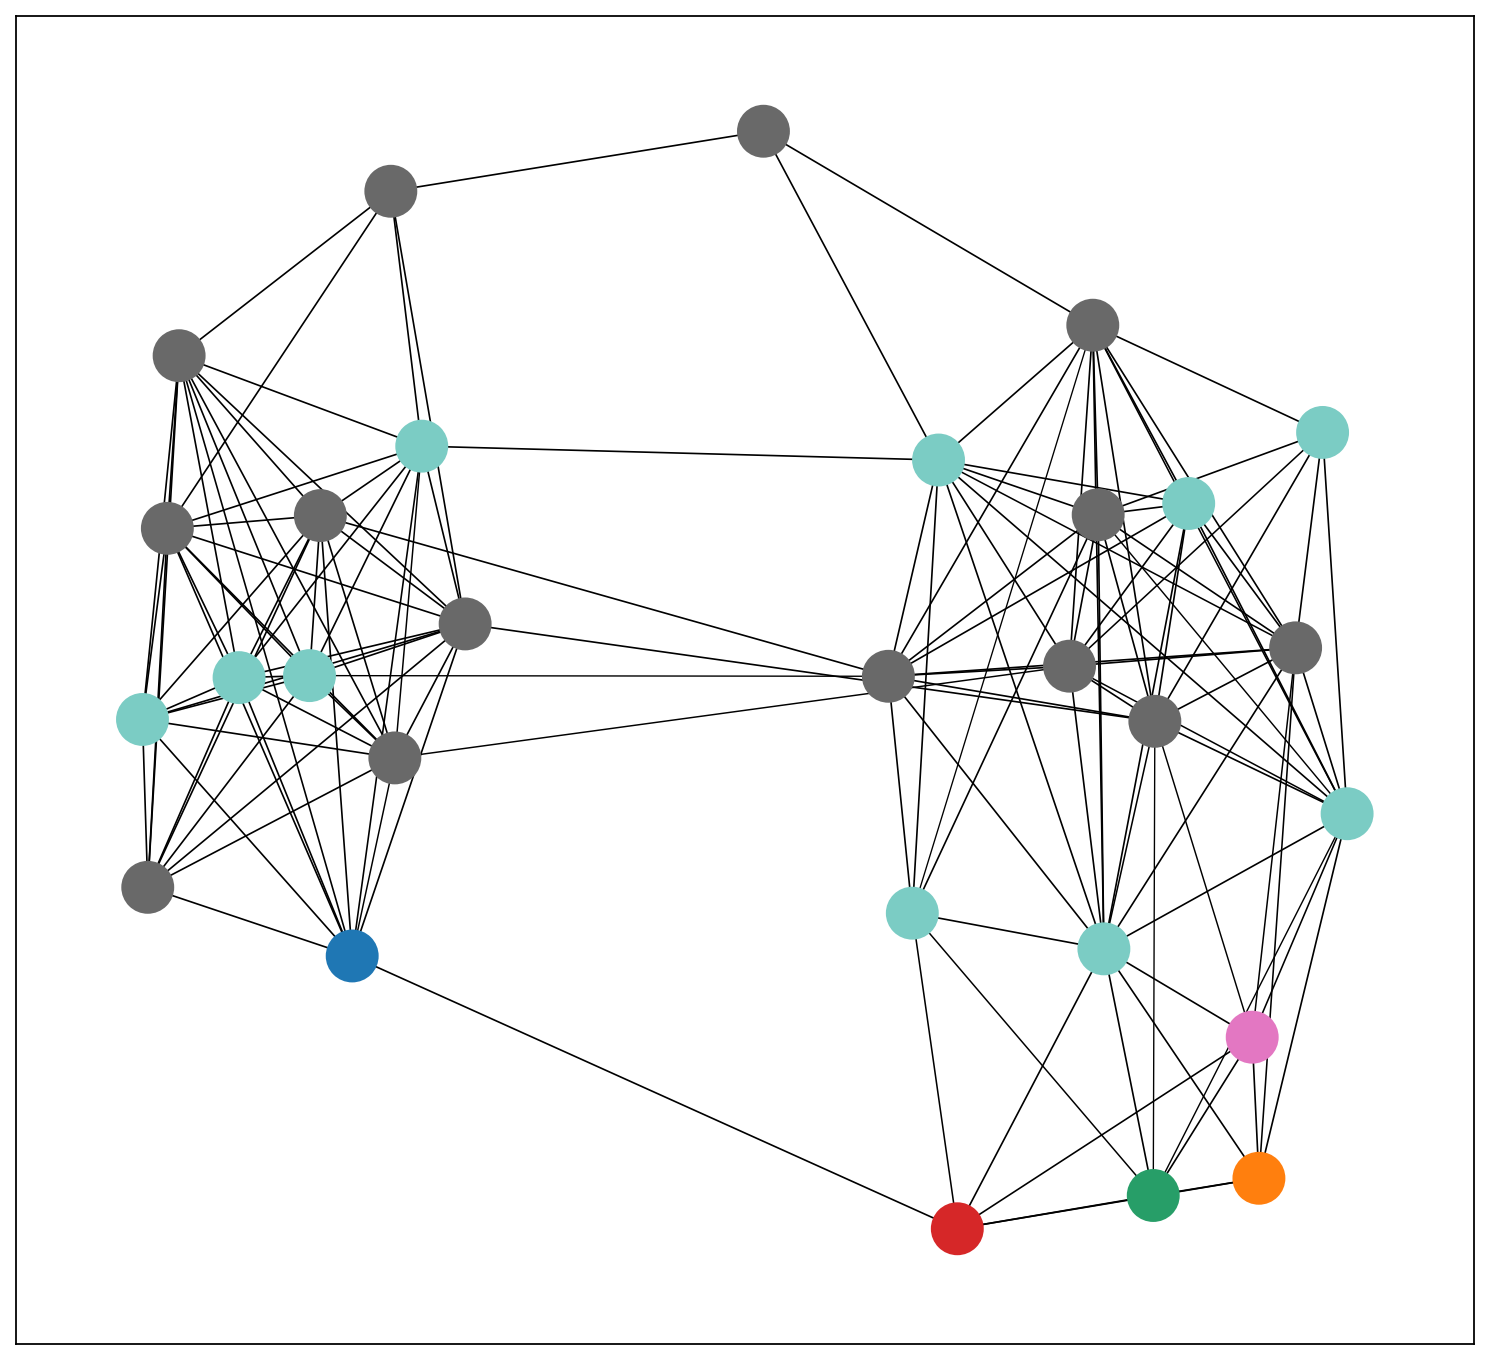

In [35]:
sc.pl.paga(paga_adata_full, node_size_power=0,export_to_gexf=True,  edge_width_scale=0.1, labels=[' ']*29,
               node_size_scale = 4, threshold=0.8, layout='fa', save='tumor_nk_mapping_all.pdf')

In [82]:
connectivities_df = pd.DataFrame(paga_adata_full.uns['paga']['connectivities'].todense(), 
                                 index=paga_adata_full.obs['subset_source'].cat.categories, 
                                 columns=paga_adata_full.obs['subset_source'].cat.categories)

In [83]:
mask = np.zeros_like(connectivities_df, dtype='bool')
mask[np.triu_indices_from(mask)] = True

In [84]:
annot = np.diag(np.diag(connectivities_df.values,-1),-1)
annot = np.round(annot,2)
annot = annot.astype('str')
annot[annot>'0.1']=''

In [85]:
font = {'family' : 'Areal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

In [86]:
import seaborn as sns

In [90]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, 
                         fontsize=10, figsize=(15,15), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

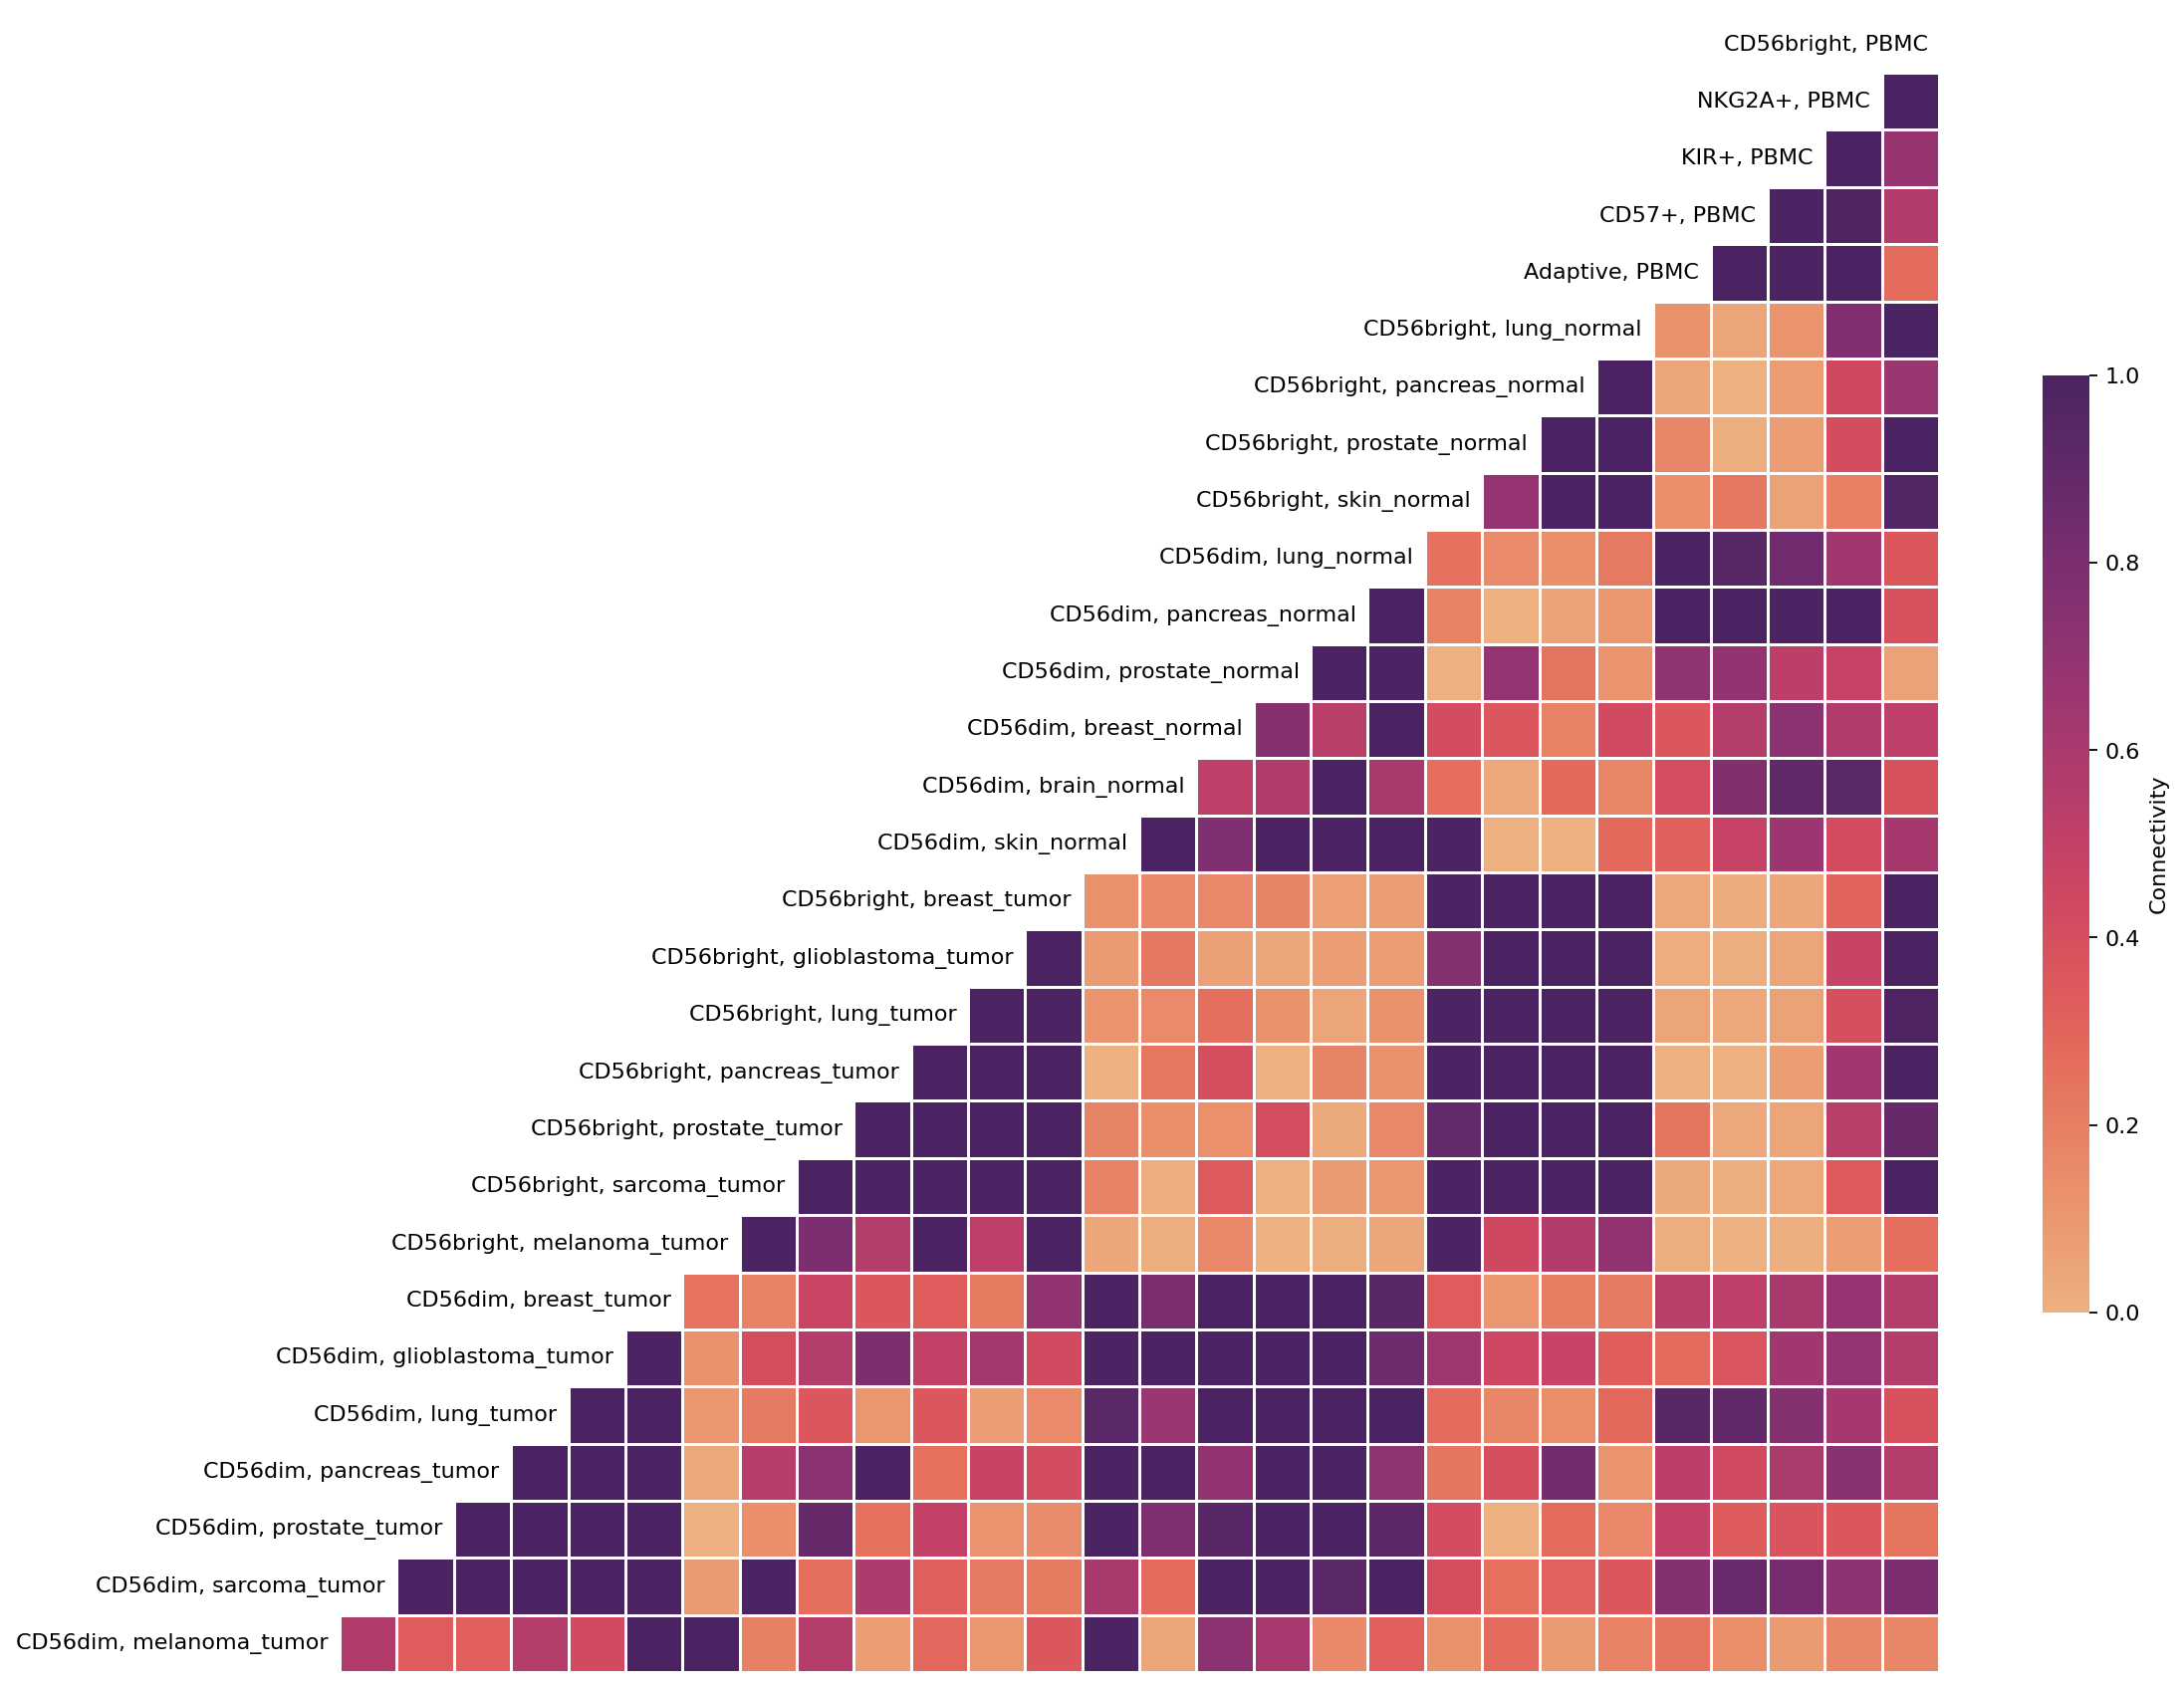

In [91]:
up_triang = np.triu(np.ones_like(connectivities_df)).astype(bool)
ax = sns.heatmap(connectivities_df, cmap='flare', xticklabels=False, yticklabels=False, square=True,
                 linecolor='white', linewidths=0.5,
                 cbar=True, mask=up_triang, cbar_kws={'shrink': 0.4, 'pad': 0.05, 'label': 'Connectivity'})
ax.invert_xaxis()
for i, label in enumerate(connectivities_df.index):
    ax.text(i + 0.2, i + 0.5, label, ha='right', va='center')
plt.tight_layout()
plt.savefig(os.path.join(sc.settings.figdir, 'connectivites_heatmap_all_subsets_tumors.pdf'))

In [72]:
query_model.save('query_model_all_tink', overwrite=True)

### AUCell

In [ ]:
tr_genes = ['CD69', 'ITGAE', 'ITGA1', 'CXCR6', 'ZNF683', 'S1PR5', 'S1PR1', 'CD101', 'IKZF3']

In [99]:
signature_genes = [tr_genes]
signature_names = ['Tissue residency']

In [99]:
gene_sigs = [GeneSignature(name,genes) for (name,genes) in zip(signature_names, signature_genes)]

In [100]:
exp_df = adata_full_foo.to_df()

In [105]:
auc_mtx = aucell(exp_df, gene_sigs, num_workers=4)

In [107]:
adata_full.obs[[x + '_auc' for x in auc_mtx.columns]] = auc_mtx.to_numpy()

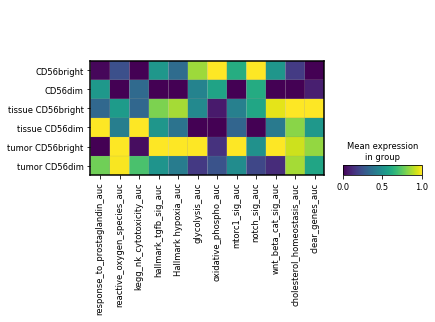

In [15]:
sc.pl.matrixplot(adata_full, ['response_to_prostaglandin_auc','reactive_oxygen_species_auc', 'kegg_nk_cytotoxicity_auc','hallmark_tgfb_sig_auc', 'Hallmark hypoxia_auc', 'glycolysis_auc', 'oxidative_phospho_auc',
                             'mtorc1_sig_auc', 'notch_sig_auc', 'wnt_beta_cat_sig_auc', 'cholesterol_homeostasis_auc', 'clear_genes_auc'], standard_scale='var', 
                 groupby='low_res_subset')#, save='auc_gene_sets_normalized.pdf')